## <img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 1
#### Gonzalo Lavigna

***
## Procesos Aleatorios



<div class="alert alert-block alert-info">
<b>1)</b> Analizamos el pulso de referencia dado por la catedra
</div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sc
from scipy import signal

def simple_fft(yy,fs,N):
    """
    brief:  Genera la DFT, pero utilizando la FFT como algoritmo
    Entradas
    yy: Señal de entrada a convertir en DFT
    ts: Tiempo de sampleo en segundos
    N:  Numero de muestras de la señal
    
    Salidas
    ff: Campo de las frecuencias para poder hacer un grafico
    XX: Espectro de la señal en valor absoluto y solo una mitad.
        Magnitud Normalizada.
    """
    
    delta_f = (fs/2)/(N//2) ;
    
    XX = (2/N)*np.abs(sc.fft(yy));
    XX = XX[0:N//2];
    ff = np.linspace(0,(fs/2)-delta_f,N//2);
     
    return ff,XX

<StemContainer object of 3 artists>

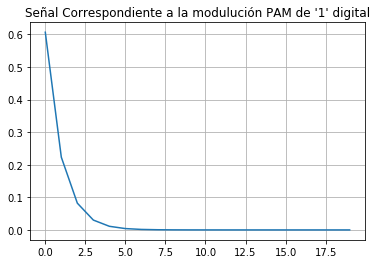

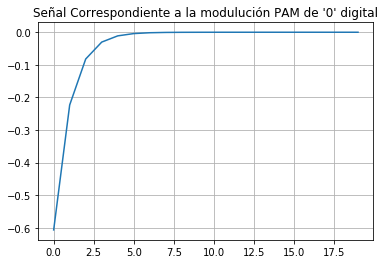

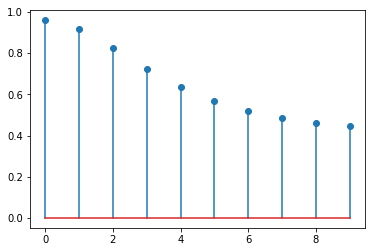

In [19]:
#Abrimos el archivo correspondiente al pulso y lo terminamos graficando
pulse = np.load('pulse.npy')
plt.figure(1)
plt.plot(pulse)
plt.title("Señal Correspondiente a la modulución PAM de '1' digital")
plt.grid()

plt.figure(2)
plt.plot(-1*pulse)
plt.title("Señal Correspondiente a la modulución PAM de '0' digital")
plt.grid()


#Dibujamos la FFT, adaptado de la funcion de PSF con frecuencia de muestreo igual a 1
pulse_fft_db = 20*np.log10(np.abs(sc.fft(pulse )))
pulse_fft    = np.abs(sc.fft(pulse ))
half_fft     = pulse_fft[0:len(pulse_fft)//2]
plt.figure(3)
plt.stem(half_fft)


<div class="alert alert-block alert-info">
<b>2)</b> El espectro de la señal ocupa todo el posible espectro en todas las frecuencia. Por ende cualquier filtro digital que hagamos va sacarnos un porcentaje de la señal util. 
</div>
<div class="alert alert-block alert-info">
<b>3)</b> La idea a paretir de ahora es generar una secuencia del header del bitstream recibido para ver como queda a la salida de los filtros digitales propuestos y ver si podemos seguir reconociendo la informacion.
</div>


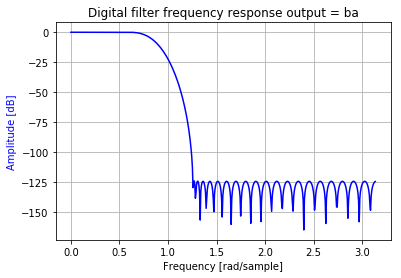

In [242]:
#Load low pass FIR este filtro fue generado por la herramienta pyfda
#Cargamos el filtro digital para ver su transferencia.
#Podemos sacarle mucho ruido de esta manera
files = np.load('low_pass_filter_2.npz')
coefficient=files['ba.npy']
b = coefficient[0].flatten()
a = coefficient[1].flatten()

w, h = signal.freqz(b,a)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response output = ba')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
ax1.grid()

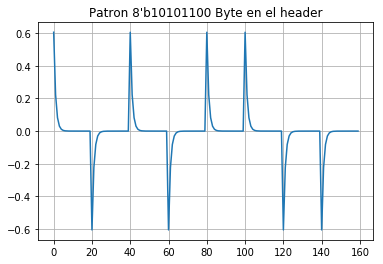

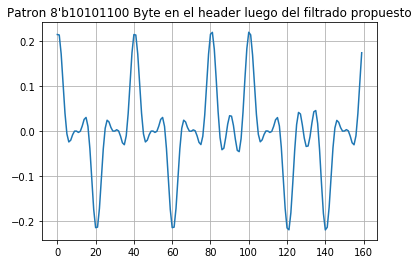

In [243]:
#Generamos a modo de ejemplo una secuencia correspondiente al header de la señal

bit_samples  = 20
bit_in_bytes = 8
bytes_in_header = 16

first_slice  = bit_samples*bit_in_bytes
second_slice = 2*bit_samples*bit_in_bytes

header_bit_stream = np.concatenate((pulse, -pulse, pulse,-pulse,pulse,pulse,-pulse,-pulse), axis=0)
header_bit_stream = np.tile(header_bit_stream,bytes_in_header)
plt.figure(4)
plt.plot(header_bit_stream[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header")
plt.grid()

#Aplicamos la tecnica que genera dos veces el filtrado de esta manera eliminada el retardo de grupo.
header_bit_stream_lp = signal.filtfilt(b,a,header_bit_stream)
plt.figure(5)
plt.plot(header_bit_stream_lp[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header luego del filtrado propuesto")
plt.grid()


In [251]:
#Lo que hacemos es ver en un offset si mayor o menor que cero un valor.
def threshold_level_decision(vector,offset):
    if(vector[offset] > 0):
        return 1
    else :
        return 0
    
#Lo analizamos teniendo en cuenta cuantas derivada negativas hay y cuantas positivas
def threshold_edge_decision(vector,offset_low,offset_high):
    low_edge  = 0
    high_edge = 0
    
    for i in range(offset_high - offset_low):
        if(vector[i+offset_low+1]  > vector[i+offset_low]):
            high_edge += (vector[i+offset_low+1]-vector[i+offset_low])
        else :
            low_edge  += (vector[i+offset_low] - vector[i+offset_low+1])
    
    #Significa que tenemos una señal que tiene pendiente positiva en su mayor
    if(high_edge > low_edge):
        return 0
    else:
        return 1
        

#Generamos el arreglo de unos y ceros a partir de una señal de entrada
offset     = 4
low_slice  = 0
high_slice = 0 

bit_array = np.array([])
bit_array_edge = np.array([])

for i in range((bit_in_bytes*bytes_in_header)):
    low_slice = i*20;
    high_slice = (i+1)*20
    vector_slice = header_bit_stream_lp[low_slice : high_slice]    
    bit_array=np.append(bit_array,threshold_level_decision(vector_slice,offset))

low_slice  = 0    
high_slice = 8  
byte_index = 0
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array[low_slice:high_slice]))
    

Header BYTE 0:[0. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 1:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 2:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 3:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 4:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 5:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 6:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 7:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 8:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 9:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 10:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 11:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 12:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 13:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 14:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 15:[1. 0. 1. 0. 1. 1. 0. 0.]


<div class="alert alert-block alert-info">
<b>4)</b> Analizamos la señal que no tiene tanto ruido que es intermedia para ver como funciona el filtrado.
</div>

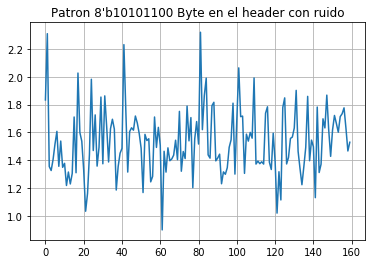

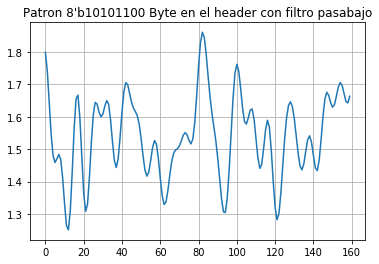

In [252]:
signal_low_noise           = np.load('signalLowSNR.npy')
signal_low_noise_filtered  = signal.filtfilt(b,a,signal_low_noise)

first_slice  = 1*bit_samples*bit_in_bytes
second_slice = 2*bit_samples*bit_in_bytes

plt.figure(6)
plt.plot(signal_low_noise[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header con ruido")
plt.grid()

plt.figure(7)
plt.plot(signal_low_noise_filtered[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header con filtro pasabajo")
plt.grid()


#Generamos el arreglo de unos y ceros a partir de una señal de entrada
offset      = 3
low_slice   = 0
high_slice  = 0 

bit_array_low_noise      = np.array([])
bit_array_low_noise_edge = np.array([])

for i in range((bit_in_bytes*bytes_in_header)):
    low_slice  = i*20;
    high_slice = (i+1)*20
    #Le restamos la media para sacar la continua en lo que respecta a esta slice
    vector_slice = signal_low_noise_filtered[low_slice : high_slice] - np.mean(signal_low_noise_filtered[low_slice : high_slice])
    bit_array_low_noise      = np.append(bit_array_low_noise,threshold_level_decision(vector_slice,offset))


In [260]:
def number_of_incorrect_bits(pattern_bits,decoded_bits):
    return np.sum(np.abs(pattern_bits - decoded_bits))

print("Cantidad de bits incorrectos metodo muestreo unico:{}".format(number_of_incorrect_bits(bit_array,bit_array_low_noise)))   
    

Cantidad de bits incorrectos metodo muestreo unico:7.0


In [261]:
low_slice  = 0    
high_slice = 8  
byte_index = 0
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_low_noise[low_slice:high_slice]))


Header BYTE 0:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 1:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 2:[1. 0. 1. 1. 1. 1. 0. 0.]
Header BYTE 3:[1. 0. 1. 0. 1. 0. 0. 0.]
Header BYTE 4:[1. 0. 1. 0. 1. 1. 1. 0.]
Header BYTE 5:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 6:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 7:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 8:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 9:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 10:[1. 0. 1. 1. 1. 1. 0. 0.]
Header BYTE 11:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 12:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 13:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 14:[0. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 15:[1. 0. 1. 0. 0. 1. 0. 0.]


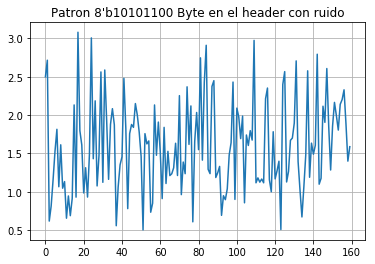

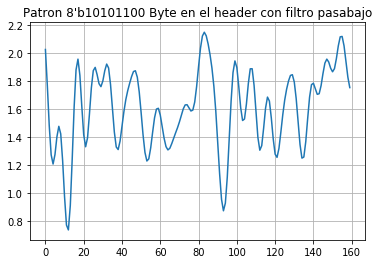

In [257]:
signal_noise           = np.load('signal.npy')
signal_noise_filtered  = signal.filtfilt(b,a,signal_noise)

first_slice  = 1*bit_samples*bit_in_bytes
second_slice = 2*bit_samples*bit_in_bytes

plt.figure(6)
plt.plot(signal_noise[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header con ruido")
plt.grid()

plt.figure(7)
plt.plot(signal_noise_filtered[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header con filtro pasabajo")
plt.grid()


#Generamos el arreglo de unos y ceros a partir de una señal de entrada
offset      = 3
low_slice   = 0
high_slice  = 0 

bit_array_noise      = np.array([])
bit_array_noise_edge = np.array([])

for i in range((bit_in_bytes*bytes_in_header)):
    low_slice  = i*20;
    high_slice = (i+1)*20
    #Le restamos la media para sacar la continua en lo que respecta a esta slice
    vector_slice    = signal_noise_filtered[low_slice : high_slice] - np.mean(signal_noise_filtered[low_slice : high_slice])
    bit_array_noise = np.append(bit_array_noise,threshold_level_decision(vector_slice,offset))    


In [258]:
def number_of_incorrect_bits(pattern_bits,decoded_bits):
    return np.sum(np.abs(pattern_bits - decoded_bits))

print("Cantidad de bits incorrectos metodo muestreo unico:{}".format(number_of_incorrect_bits(bit_array,bit_array_noise)))
    

Cantidad de bits incorrectos metodo muestreo unico:35.0


In [259]:
low_slice  = 0    
high_slice = 8  
byte_index = 0
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))
low_slice  += 8
high_slice += 8
byte_index += 1
print("Header BYTE {}:{}".format(byte_index,bit_array_noise[low_slice:high_slice]))

Header BYTE 0:[1. 1. 1. 0. 1. 1. 0. 0.]
Header BYTE 1:[0. 0. 1. 0. 1. 0. 0. 0.]
Header BYTE 2:[1. 0. 1. 1. 1. 1. 1. 1.]
Header BYTE 3:[0. 0. 1. 1. 1. 0. 1. 1.]
Header BYTE 4:[1. 0. 1. 1. 1. 1. 1. 1.]
Header BYTE 5:[1. 0. 1. 0. 0. 1. 0. 0.]
Header BYTE 6:[1. 0. 1. 0. 0. 1. 0. 0.]
Header BYTE 7:[1. 0. 1. 1. 0. 1. 0. 0.]
Header BYTE 8:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 9:[0. 0. 1. 0. 1. 1. 0. 1.]
Header BYTE 10:[1. 0. 1. 1. 1. 0. 0. 1.]
Header BYTE 11:[1. 0. 1. 0. 1. 1. 0. 1.]
Header BYTE 12:[1. 1. 0. 0. 1. 1. 1. 0.]
Header BYTE 13:[1. 0. 1. 0. 1. 1. 0. 1.]
Header BYTE 14:[0. 0. 1. 0. 0. 0. 0. 0.]
Header BYTE 15:[1. 0. 1. 0. 0. 0. 1. 0.]
